### Set autoreloading
This extension will automatically update with any changes to packages in real time

In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import packages
We'll need the `pytorch_lightning` and `nugraph` packages imported in order to train

In [116]:
import nugraph as ng
import pytorch_lightning as pl

import torch
import tqdm
import torchmetrics as tm
import plotly.graph_objects as go

### Set default plotting options

Define a dictionary containing all standard plotting options that we want to set for all the plots we draw

In [117]:
style = {
    'layout_width': 800,
    'layout_height': 450,
    'layout_margin_b': 20,
    'layout_margin_t': 20,
    'layout_margin_r': 20,
    'layout_margin_l': 20,
    'layout_xaxis_title_font_size': 24,
    'layout_xaxis_tickfont_size': 20,
    'layout_yaxis_title_font_size': 24,
    'layout_yaxis_tickfont_size': 20,
    'layout_legend_font_size': 20,
}

### Define label score metrics

Define a torchmetrics class to make true & false score distributions for each semantic label

In [118]:
class Score(tm.Metric):
    def __init__(self,
                 num_classes: int,
                 bins: int = 20,
                 range: tuple[float] = (0,1),
                 ignore_index: int = None):
        super().__init__()

        self.bins = bins
        self.range = range
        self.ignore_index = ignore_index
        
        self.add_state('true', default=torch.zeros(num_classes, bins), dist_reduce_fx = 'sum')
        self.add_state('false', default=torch.zeros(num_classes, bins), dist_reduce_fx = 'sum')

    def update(self, preds: torch.Tensor, target: torch.Tensor):

        # check that number of classes is correct
        num_classes = preds.size(1)
        assert num_classes == self.true.size(0)

        # loop over labels
        filter = (target != self.ignore_index)
        for label in range(num_classes):
            mask = filter & (target == label)
            hist, bin_edges = preds[mask, label].histogram(bins=self.bins,
                                                           range=self.range)
            self.true[label] += hist
            mask = filter & (target != label)
            hist, bin_edges = preds[mask, label].histogram(bins=self.bins,
                                                           range=self.range)
            self.false[label] += hist
        
    def compute(self):
        true = self.true / self.true.sum(dim=1)[:,None]
        false = self.false / self.false.sum(dim=1)[:,None]
        return true, false

### Configure data module
Declare a data module. Depending on where you're working, you should edit the data path below to point to a valid data location.

In [126]:
#nudata = ng.data.H5DataModule(data_path='/cshare/vol2/users/tstokes/Sample_Size_Test/Processed_60K.h5.0000.h5', batch_size=64)
nudata = ng.data.H5DataModule(data_path='/cshare/vol2/users/tstokes/GNN_Samples_PDK/New_PDK_Atm_Mixer/Input_Files/Processed_hA_LFG_400K_PDK_400K_Atm.h5', batch_size=64)

### Configure network
In order to test a trained model, we instantiate it using a checkpoint file. These are produced during training, so if you've trained a model, there should be an associated checkpoint in your output directory that you can pass here.

In [127]:
model = ng.models.NuGraph3.load_from_checkpoint('/home/stokes/NEW_WORK/GNN_Work/NuGraph_Multi_Training/hA_LFG60K/version_2/checkpoints/epoch=79-step=121440.ckpt', map_location='cpu')
model.freeze()

/home/stokes/mambaforge/envs/numl/lib/python3.11/site-packages/torch_geometric/nn/conv/hetero_conv.py:76: UserWarning:

There exist node types ({'y', 'v', 'u'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.

/home/stokes/mambaforge/envs/numl/lib/python3.11/site-packages/torch_geometric/nn/conv/hetero_conv.py:76: UserWarning:

There exist node types ({'sp'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.

/home/stokes/mambaforge/envs/numl/lib/python3.11/site-packages/torch_geometric/nn/conv/hetero_conv.py:76: UserWarning:

There exist node types ({'evt'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.



### Declare trainer and run testing
First we set the training device. In the instance that we're in a multi-GPU environment, the code will automatically select the GPU with the most available memory; otherwise, it defaults to CPU training. We then instantiate a PyTorch Lightning trainer that we'll use for testing, and then run the testing stage, which iterates over all batches in the test dataset and prints performance metrics.

In [128]:
accelerator, devices = ng.util.configure_device()
trainer = pl.Trainer(accelerator="gpu",
                     devices=devices,
                     logger=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Calculate testing metrics

Loop over each batch and produce testing plots: score distributions and ROC curves per label.

In [129]:
num_classes = len(nudata.semantic_classes)
num_classes_Evt = len(nudata.event_classes)

score = Score(num_classes, ignore_index=-1)
event_score = Score(num_classes_Evt, ignore_index=-1)  # For event-level classes
all_event_scores = []
all_pdk_event_scores = []
all_nu_event_scores = []
all_y_true = [] 
true_nu_event_scores = []
true_pdk_event_scores = []


roc_event = tm.classification.MulticlassROC(
    num_classes=num_classes_Evt,
    thresholds=5399,
)
roc_semantic = tm.classification.MulticlassROC(
    num_classes=num_classes,
    thresholds=5399,
    ignore_index=-1,
)

batches = trainer.predict(model, nudata.test_dataloader())
total_events = len(nudata.test_dataset)  # Directly access the number of events from the dataset
total_events_train = len(nudata.train_dataset)
total_events_val   = len(nudata.val_dataset)



for batch in tqdm.tqdm(batches):
    if hasattr(model,"event_decoder"):
        # Access the predictions and truth directly
        e_pred = batch["evt"].e
        y_true = batch["evt"].y  

        pdk_scores = e_pred[:, 1].cpu().numpy()  # Second index is for PDK
        nu_scores = e_pred[:, 0].cpu().numpy()  # First index is for NU

       # print(f"Shape of e_pred: {e_pred.shape}")
       # print(f"Example predictions: {e_pred[:5]}")

        e_pred = e_pred.to(y_true.device)
        y_true = y_true.to(e_pred.device)

        roc_event.update(e_pred, y_true)
        event_score.update(e_pred, y_true)
        all_event_scores.append(e_pred.cpu().numpy())
        all_pdk_event_scores.append(pdk_scores)
        all_nu_event_scores.append(nu_scores)
        all_y_true.append(y_true.cpu().numpy())
        true_nu_event_scores.append(nu_scores[y_true.cpu().numpy() == 0])
        true_pdk_event_scores.append(pdk_scores[y_true.cpu().numpy() == 1])


    # Update metrics for each plane
    for p in nudata.planes:
        if 'x_semantic' in batch[p] and 'y_semantic' in batch[p]:
            x_semantic = batch[p]['x_semantic']
            y_semantic = batch[p]['y_semantic']
            if isinstance(x_semantic, torch.Tensor) and isinstance(y_semantic, torch.Tensor):
                score.update(x_semantic, y_semantic)
                roc_semantic.update(x_semantic, y_semantic)


all_event_scores = np.concatenate(all_event_scores, axis=0)
all_pdk_event_scores = np.concatenate(all_pdk_event_scores, axis=0)
all_nu_event_scores = np.concatenate(all_nu_event_scores, axis=0)
all_y_true = np.concatenate(all_y_true, axis=0)
true_nu_event_scores = np.concatenate(true_nu_event_scores, axis=0)
true_pdk_event_scores = np.concatenate(true_pdk_event_scores, axis=0)

assert all_event_scores.shape[0] == total_events, f"Expected {total_events} scores, but got {all_event_scores.shape[0]}."
assert all_pdk_event_scores.shape[0] == total_events, f"Expected {total_events} PDK scores, but got {all_pdk_event_scores.shape[0]}."
assert all_nu_event_scores.shape[0] == total_events, f"Expected {total_events} NU scores, but got {all_nu_event_scores.shape[0]}."

true, false = score.compute()
fpr_semantic, tpr_semantic, thresholds = roc_semantic.compute()
fpr_event, tpr_event, thresholds = roc_event.compute()
event_true, event_false = event_score.compute()


print(f"Total events processed: {total_events}") 
print(f"Total events trained on: {total_events_train}")
print(f"Total events validated on: {total_events_val}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


100%|██████████| 562/562 [2:30:46<00:00, 16.10s/it]

Total events processed: 35916
Total events trained on: 646499
Total events validated on: 35916


### Filter ROC curve

Draw ROC curve for filter decoder

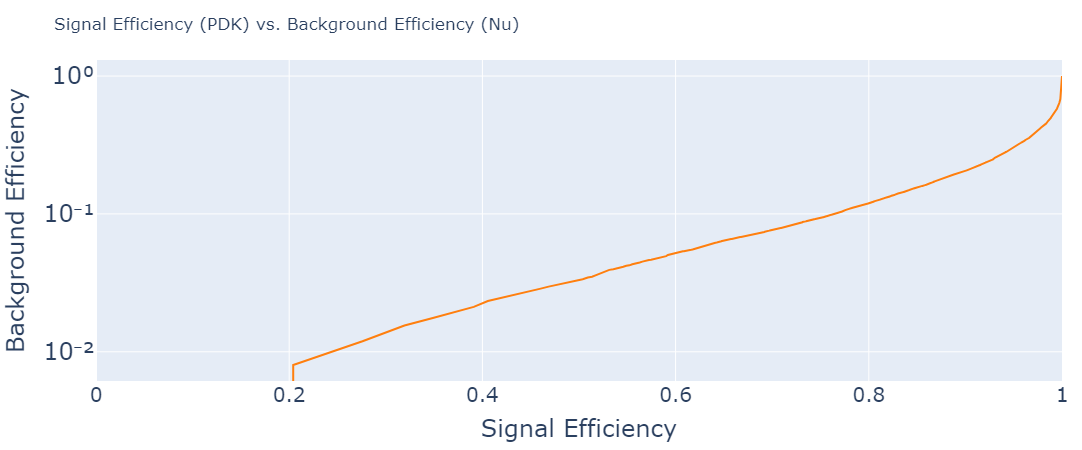

In [130]:
import os
import plotly.graph_objects as go

# Create the directory if it does not exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# Define colors for each event class
color_map = {
    'nu': '#1f77b4',  # Blue
    'pdk': '#ff7f0e',  # Orange
    # Add other event classes and colors as needed
}

# Adding the title to the style
style = {
    'layout_width': 800,
    'layout_height': 450,
    'layout_margin_b': 20,
    'layout_margin_t': 60,
    'layout_margin_r': 20,
    'layout_margin_l': 20,
    'layout_xaxis_title_font_size': 24,
    'layout_xaxis_tickfont_size': 20,
    'layout_yaxis_title_font_size': 24,
    'layout_yaxis_tickfont_size': 24,
    'layout_legend_font_size': 20,
    'layout_title': 'Signal Efficiency (PDK) vs. Background Efficiency (Nu)'  # Adding the title
}

# Create the figure with the provided layout
fig = go.Figure(
    layout=dict(
        width=style['layout_width'],
        height=style['layout_height'],
        margin=dict(
            b=style['layout_margin_b'],
            t=style['layout_margin_t'],
            r=style['layout_margin_r'],
            l=style['layout_margin_l']
        ),
        title=style['layout_title'],
        xaxis=dict(
            title='Signal Efficiency',
            title_font=dict(size=style['layout_xaxis_title_font_size']),
            tickfont=dict(size=style['layout_xaxis_tickfont_size']),
            range=(0, 1)
        ),
        yaxis=dict(
            title='Background Efficiency',
            title_font=dict(size=style['layout_yaxis_title_font_size']),
            tickfont=dict(size=style['layout_yaxis_tickfont_size']),
            type="log",  # Set y-axis to log scale
            tickvals=[1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],  # Specify the ticks to match the desired scale
            ticktext=['10⁰', '10⁻¹', '10⁻²', '10⁻³', '10⁻⁴', '10⁻⁵', '10⁻⁶'],  # Custom tick labels using superscripts
            tickformat=".1e"
        ),
        legend=dict(
            font=dict(size=style['layout_legend_font_size']),
            x=0.9,
            y=0.14,
            xanchor='right',
            yanchor='bottom'
        ),
       
    )
)

# Assuming 'nudata.event_classes' and 'fpr_event', 'tpr_event' data are defined
# Find the index for the 'pdk' class
pdk_index = nudata.event_classes.index('pdk')

# Plot the PDK ROC curve with signal efficiency on the x-axis
fig.add_scatter(
    x=tpr_event[pdk_index],  # Use TPR (Signal Efficiency for PDK) on the x-axis
    y=fpr_event[pdk_index],  # Use FPR (Background Efficiency for Nu) on the y-axis
    name='PDK',
    line=dict(color=color_map.get('pdk', '#ff7f0e'))  # Use the orange color for PDK
)

# Optionally, you can save the plot as an image or PDF
fig.write_image('plots/roc-pdk-signal-efficiency-log.pdf')
fig.write_image('plots/roc-pdk-signal-efficiency-log.png')

# Display the plot
fig.show()

### Plot semantic ROC curves

Draw semantic ROC curves for each semantic class on the same axes

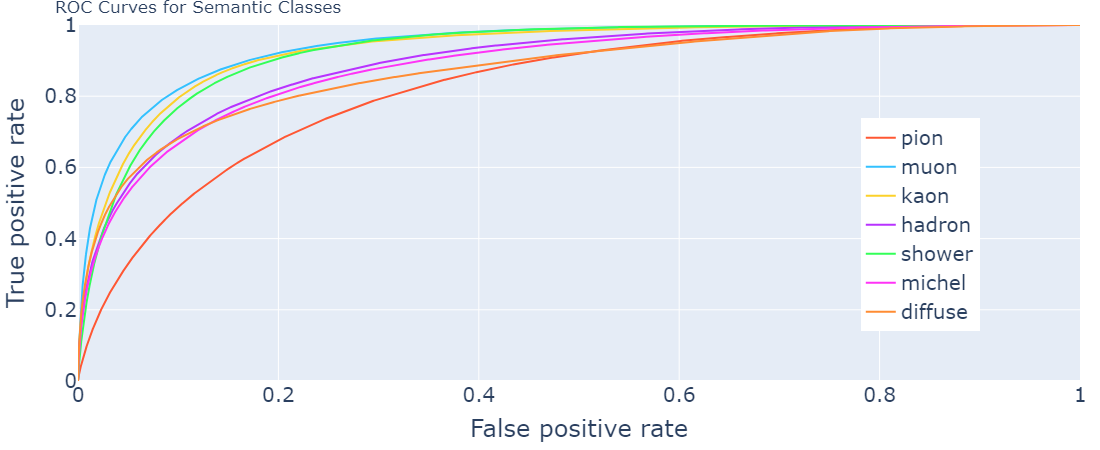

In [83]:
import os
import plotly.graph_objects as go

# Create the directory if it does not exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# Define colors for each category
color_map = {
    'pion': '#FF5733',  # Bright red
    'muon': '#33C1FF',  # Light blue
    'kaon': '#FCD12A',  # Yellow
    'hadron': '#B833FF',  # Purple
    'shower': '#33FF57',  # Bright green
    'michel': '#FF33F6',  # Magenta
    'diffuse': '#FF8C33'  # Orange
}

# Adding the title to the style
style = {
    'layout_width': 800,
    'layout_height': 450,
    'layout_margin_b': 20,
    'layout_margin_t': 20,
    'layout_margin_r': 20,
    'layout_margin_l': 20,
    'layout_xaxis_title_font_size': 24,
    'layout_xaxis_tickfont_size': 20,
    'layout_yaxis_title_font_size': 24,
    'layout_yaxis_tickfont_size': 20,
    'layout_legend_font_size': 20,
    'layout_title': 'ROC Curves for Semantic Classes'  # Adding the title
}

fig = go.Figure(
    layout_xaxis_title='False positive rate',
    layout_xaxis_range=(0, 1),
    layout_yaxis_title='True positive rate',
    layout_yaxis_range=(0, 1),
    layout_legend_xanchor='right',
    layout_legend_x=0.9,
    layout_legend_yanchor='bottom',
    layout_legend_y=0.14,
    **style,
)

# Assuming 'nudata.semantic_classes' and 'fpr_semantic', 'tpr_semantic' data are defined
for label, name in enumerate(nudata.semantic_classes):
    fig.add_scatter(
        x=fpr_semantic[label], 
        y=tpr_semantic[label], 
        name=name,
        line=dict(color=color_map[name])  # Set color based on the category
    )

# Optionally, you can save the plot as an image or PDF
fig.write_image('plots/roc-semantic.pdf')
fig.write_image('plots/roc-semantic.png')

# Display the plot
fig.show()


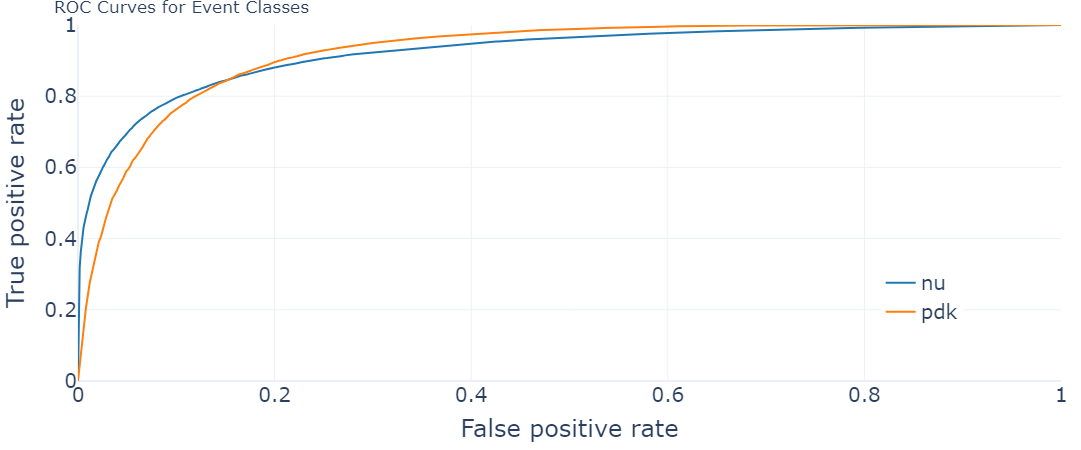

In [131]:
import os
import plotly.graph_objects as go

# Create the directory if it does not exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# Define colors for each event class (you can customize these based on your preferences)
color_map = {
    'nu': '#1f77b4',  # Blue
    'pdk': '#ff7f0e',  # Orange
    # Add other event classes and colors as needed
}

# Create an empty figure
fig = go.Figure()

# Assuming 'nudata.event_classes' and 'fpr_event', 'tpr_event' data are defined
for label, name in enumerate(nudata.event_classes):
    fig.add_scatter(
        x=fpr_event[label], 
        y=tpr_event[label], 
        name=name,
        line=dict(color=color_map.get(name, '#000000'))  # Set color based on the event class, default to black if not found
    )

# Style settings
style = {
    'width': 800,
    'height': 450,
    'margin_b': 20,
    'margin_t': 20,
    'margin_r': 20,
    'margin_l': 20,
    'xaxis_title_font_size': 24,
    'xaxis_tickfont_size': 20,
    'yaxis_title_font_size': 24,
    'yaxis_tickfont_size': 20,
    'legend_font_size': 20,
}

# Update layout with your style settings
fig.update_layout(
    title="ROC Curves for Event Classes",
    xaxis_title="False positive rate",
    yaxis_title="True positive rate",
    xaxis_range=(0, 1),
    yaxis_range=(0, 1),
    legend=dict(
        x=0.9,
        y=0.14,
        xanchor='right',
        yanchor='bottom'
    ),
    template="plotly_white",
    **style  # Apply the style dictionary
)

# Optionally, you can save the plot as an image or PDF
fig.write_image('plots/roc-event.pdf')
fig.write_image('plots/roc-event.png')

# Display the plot
fig.show()

### Plot score distributions

For true and false predictions, draw the score distributions for each semantic class on the same axes

The x value (FPR) for 'Nu' where TPR is closest to 0.995 is: 0.20414680242538452


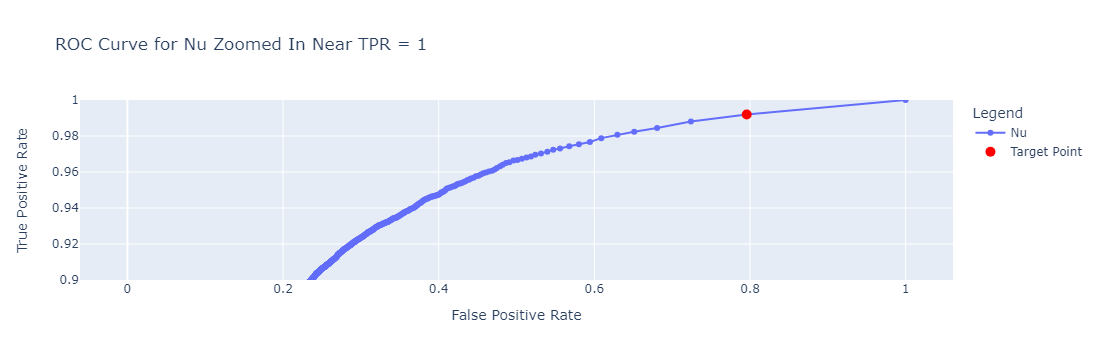

In [133]:
import numpy as np
import plotly.graph_objects as go

# Assuming 'fpr_event' and 'tpr_event' are lists of numpy arrays for each class
# and 'nudata.event_classes' contains class names with "Nu" at a known index
nu_index = nudata.event_classes.index("nu")  # Get the index for "Nu"
x_values = fpr_event[nu_index]  # FPR values for Nu
y_values = tpr_event[nu_index]  # TPR values for Nu

# Find the x value where y is closest to 0.995
closest_y_index = np.abs(y_values - 0.995).argmin()  # Find index of closest y to 0.995
closest_x_value = x_values[closest_y_index]  # Get corresponding x value
closest_y_value = y_values[closest_y_index]  # Get the TPR value at this index

print(f"The x value (FPR) for 'Nu' where TPR is closest to 0.995 is: {1-closest_x_value}")

# Plotting the ROC curve with zoomed-in y-axis near 1
fig = go.Figure()

# Add the ROC curve for "Nu"
fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines+markers', name='Nu'))

# Highlight the closest point on the curve
fig.add_trace(go.Scatter(
    x=[closest_x_value], 
    y=[closest_y_value],  # Use the actual TPR value here
    mode='markers', 
    marker=dict(color='red', size=10), 
    name='Target Point'
))

# Update layout to zoom in on y-axis near 1
fig.update_layout(
    title="ROC Curve for Nu Zoomed In Near TPR = 1",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    yaxis_range=[0.9, 1],  # This zooms in on the y-axis close to 1
    legend_title="Legend"
)

# Show the plot
fig.show()



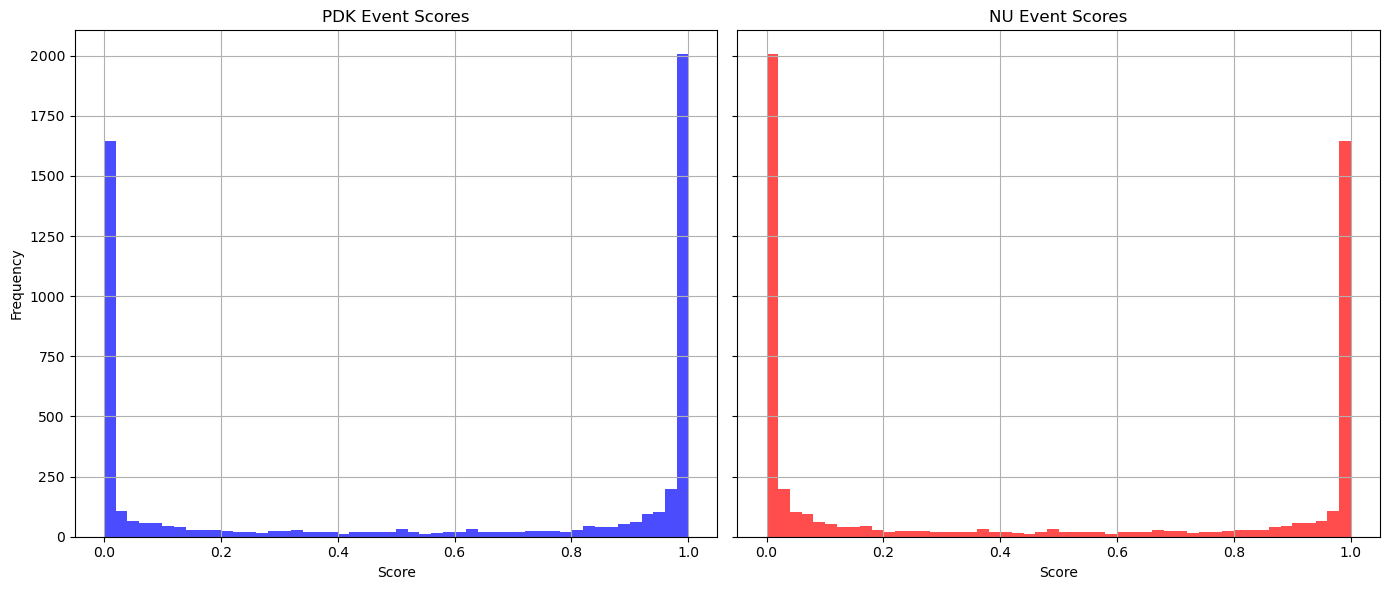

In [86]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (side by side)
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Histogram for PDK event scores on the first subplot
axs[0].hist(all_pdk_event_scores, bins=50, alpha=0.7, color='blue')
axs[0].set_title('PDK Event Scores')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

# Histogram for NU event scores on the second subplot
axs[1].hist(all_nu_event_scores, bins=50, alpha=0.7, color='red', linestyle='dashed')
axs[1].set_title('NU Event Scores')
axs[1].set_xlabel('Score')
axs[1].grid(True)

# Adjust layout to ensure the plots don't overlap
plt.tight_layout()

# Show the plot
plt.show()



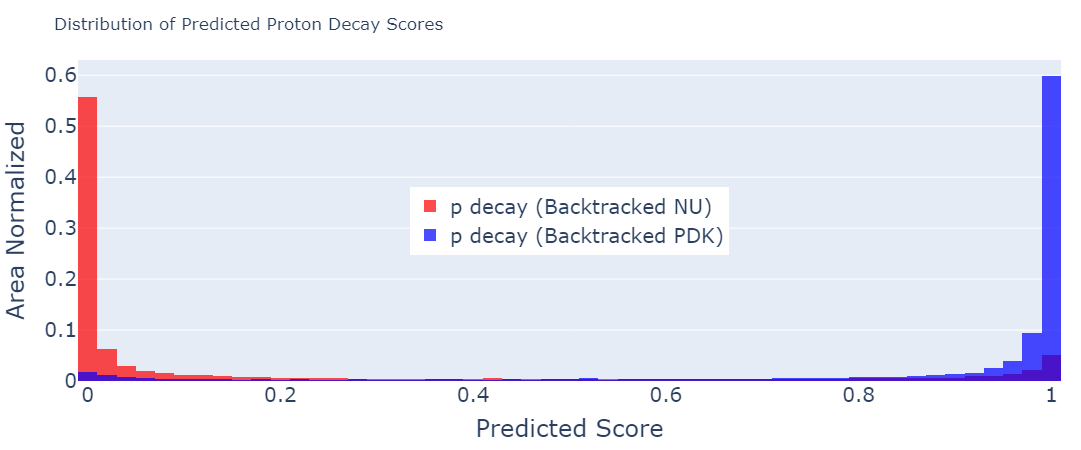

In [132]:
import plotly.graph_objects as go
import numpy as np

# Extract predicted PDK scores based on true labels
pdk_scores_for_true_nu = all_pdk_event_scores[all_y_true == 0]  # Predicted PDK scores for true NU events
pdk_scores_for_true_pdk = all_pdk_event_scores[all_y_true == 1] # Predicted PDK scores for true PDK events

# Normalize the histograms so they are comparable
weights_nu = np.ones_like(pdk_scores_for_true_nu) / len(pdk_scores_for_true_nu)
weights_pdk = np.ones_like(pdk_scores_for_true_pdk) / len(pdk_scores_for_true_pdk)

# Create histograms for PDK scores for true NU and true PDK events
fig = go.Figure()

# Histogram for PDK scores for true NU events
fig.add_trace(go.Histogram(
    x=pdk_scores_for_true_nu,
    name='p decay (Backtracked NU)',
    nbinsx=50,
    opacity=0.7,
    marker_color='red',
    histnorm='probability',  # Normalizing the histogram
))

# Histogram for PDK scores for true PDK events
fig.add_trace(go.Histogram(
    x=pdk_scores_for_true_pdk,
    name='p decay (Backtracked PDK)',
    nbinsx=50,
    opacity=0.7,
    marker_color='blue',
    histnorm='probability',  # Normalizing the histogram
))

# Update layout for the figure with adjusted margins
fig.update_layout(
    title="Distribution of Predicted Proton Decay Scores",
    xaxis_title="Predicted Score",
    yaxis_title="Area Normalized",
    barmode='overlay',  # Overlay both histograms
    legend=dict(
        x=0.5,  # Center of x-axis
        y=0.5,  # Center of y-axis
        xanchor='center',
        yanchor='middle'
    ),
    #template="plotly_white",  # Use a clean white template
    **style,  # Apply the style dictionary
    margin=dict(t=60)  # Add some padding at the top to avoid title cutoff
)

# Save the plot as an image file
fig.write_image('predicted_pdk_scores.png')  # Save as a PNG file
fig.write_image('predicted_pdk_scores.pdf')  # Save as a PDF file

# Show the plot
fig.show()





In [100]:
print(batch["evt"])

{'y': tensor([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]), 'num_nodes': 23, 'batch': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22]), 'ptr': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23]), 'e': tensor([[2.2348e-01, 7.7652e-01],
        [7.5247e-03, 9.9248e-01],
        [3.0689e-03, 9.9693e-01],
        [3.8566e-02, 9.6143e-01],
        [5.6865e-01, 4.3135e-01],
        [9.6765e-04, 9.9903e-01],
        [5.0960e-01, 4.9040e-01],
        [7.7992e-02, 9.2201e-01],
        [7.2385e-01, 2.7615e-01],
        [9.9996e-01, 4.2613e-05],
        [4.1544e-04, 9.9958e-01],
        [9.9987e-01, 1.2746e-04],
        [9.9955e-01, 4.4760e-04],
        [9.9723e-01, 2.7719e-03],
        [9.9998e-01, 2.0685e-05],
        [2.1705e-02, 9.7829e-01],
        [9.9976e-01, 2.3775e-04],
        [8.8391e-05, 9.9991e-01],
        [5.7316e-01, 4.2684e-01],
       